# Create a Qiskit Pattern for solving MaxCut for a given graph

In this tutorial, we will show how to build, deploy, and run a `Qiskit Pattern` for solving MaxCut for a given input graph. In other words, we want to find a partitionining of the graph's vertices such that the edges spanning the partitions are maximized.

For more information on `Qiskit Patterns` and how `Quantum Serverless` can be used to deploy them to the cloud for managed execution, visit our [docs page on the IBM Quantum Platform](https://docs.quantum-computing.ibm.com/run/quantum-serverless).


In [6]:
# General Imports and helper functions

import math
import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rx
import os
from rustworkx.visualization import mpl_draw

def visualize_counts(probs, num_qubits):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    top_10 = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:10])
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))
    xvals = [bin(xval)[2:].zfill(num_qubits) for xval in xvals]
    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Top 10 measured bitstrings")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Probability")
    plt.show()


def random_adjacency_matrix(N, density=0.5):
    """Create a random adjacency matrix."""
    off_elems = N * (N - 1) // 2
    num_elems = math.ceil(off_elems * density)
    inds = np.sort(np.random.choice(off_elems, size=num_elems, replace=False))
    M = np.zeros((N, N), dtype=float)
    for k in inds:
        i = N - 2 - int(math.sqrt(-8 * k + 4 * N * (N - 1) - 7) / 2 - 0.5)
        j = k + i + 1 - N * (N - 1) // 2 + (N - i) * ((N - i) - 1) // 2
        M[i, j] = 1
    M = M + M.T
    return M

## Build the Qiskit Pattern

We will implement our pattern using the four steps outlined in the [docs](https://docs.quantum-computing.ibm.com/run/quantum-serverless). First, we create a 10-node undirected graph with unweighted edges as the input.


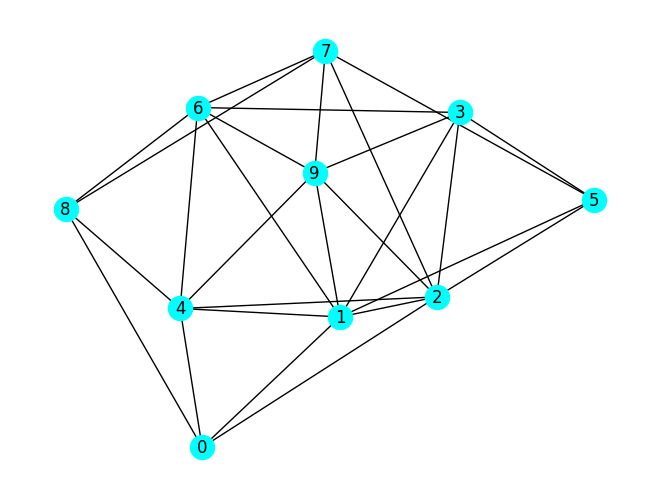

In [7]:
# Initial Problem

num_nodes = 10
density = 0.6
M = random_adjacency_matrix(num_nodes, density)
G = rx.PyGraph.from_adjacency_matrix(M)
mpl_draw(G, with_labels=True, node_color="cyan")

### Step 1: Map classical inputs to a quantum problem

*   Input: A graph
*   Output: Abstract circuit, observable, qubo, quadratic transformer


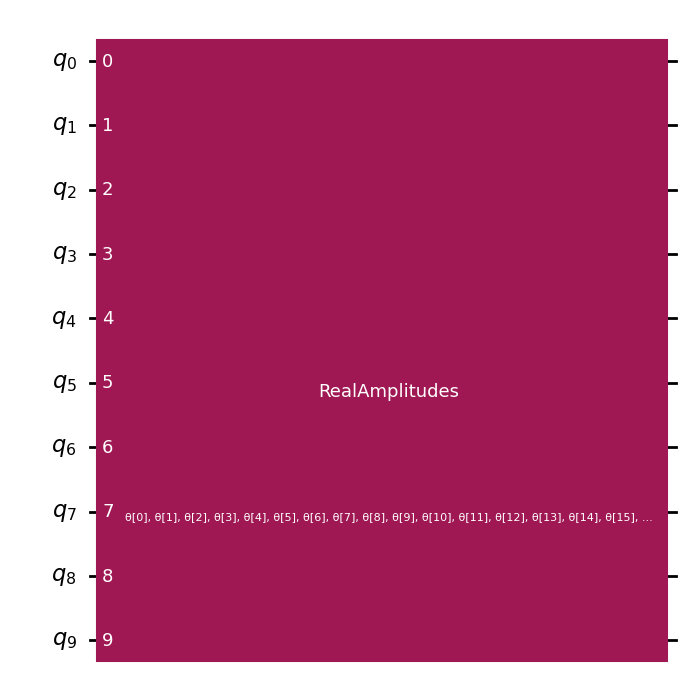

In [8]:
from qiskit.circuit.library import RealAmplitudes
from docplex.mp.model import Model
from quadratic_programs.translators import docplex_mp_to_qp, qubo_to_sparse_pauli_op
from quadratic_programs.workflows import QuadraticProgramConverter

G = rx.PyGraph.from_adjacency_matrix(M)

mdl = Model(name="Max-cut")
x = {i: mdl.binary_var(name=f"x_{i}") for i in range(G.num_nodes())}
objective = mdl.sum(
    w * x[i] * (1 - x[j]) + w * x[j] * (1 - x[i]) for i, j, w in G.weighted_edge_list()
)
mdl.maximize(objective)
qp = docplex_mp_to_qp(mdl)

quadratic_transformer = QuadraticProgramConverter()
qubo = quadratic_transformer.run(qp)
hamiltonian, offset = qubo_to_sparse_pauli_op(qubo)
ansatz = QAOA(hamiltonian.num_qubits, entanglement="linear", reps=2)
ansatz.draw("mpl", style="iqp")

### Step 2: Optimize problem for optimized quantum execution

*   Input: Abstract circuit, observable
*   Output: Target circuit and observable, optimized for the selected QPU

Use the `generate_preset_pass_manager` function from Qiskit to automatically generate an optimization routine for our circuit with respect to the selected QPU. We choose `optimization_level=3`, which provides the highest level of optimization of the preset pass managers. We also include `ALAPScheduleAnalysis` and `PadDynamicalDecoupling` scheduling passes to suppress decoherence errors.


In [13]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import XGate
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit_ibm_runtime import QiskitRuntimeService
token=os.environ['IBM_Q_HUB_API_TOKEN']
service = QiskitRuntimeService(channel='ibm_quantum', token=token)
backend = service.get_backend('simulator_mps')

In [12]:
backend

<IBMBackend('simulator_mps')>

### Step 3: Execute using Qiskit Runtime Primitives

*   Input: Target circuit and observable
*   Output: Quasi-probability distribution

Minimize the cost function by optimizing the circuit parameters. Use the `Estimator` primitive to evaluate the cost function during optimization.

Once the circuit's parameters have been optimized, use the `Sampler` primitive to reconstruct a quasi-probability distribution.

Since we optimized the circuit for the backend in Step 2, we can avoid doing transpilation on the Runtime server by setting `skip_transpilation=True` and passing the optimized circuit. For this demo, we will run on a QPU using `qiskit-ibm-runtime` primtives. To run on `qiskit` statevector-based primitives, replace the block of code using Qiskit IBM Runtime primitives with the commented block.


In [5]:
from typing import Sequence, Union

from qiskit.circuit import QuantumCircuit, ClassicalRegister
#from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from qiskit.quantum_info import SparsePauliOp
from qiskit.result import QuasiDistribution
from qiskit.primitives.base import BaseEstimator, BaseEstimatorV2

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Sampler, Session, Options

from quadratic_programs.spsa import minimize_spsa


def cost_func(
    params: Sequence,
    ansatz: QuantumCircuit,
    hamiltonian: SparsePauliOp,
    estimator: Union[BaseEstimator, BaseEstimatorV2],
) -> float:
    """Ground state energy evaluation."""
    if isinstance(estimator, BaseEstimatorV2):
        return estimator.run([(ansatz, hamiltonian, [params])]).result()[0].data.evs[0]
    else:
        return (
            estimator.run(ansatz, hamiltonian, parameter_values=params)
            .result()
            .values[0]
        )


num_shots = 10_000

# Initialisation parameters
x0 = 2 * np.pi * np.random.random(size=ansatz_ibm.num_parameters)

## Evaluate the problem using statevector-based primitives from Qiskit
#estimator = StatevectorEstimator()
#res = minimize_spsa(cost_func, x0, args=(ansatz, hamiltonian, estimator), maxiter=50)
#ansatz_opt = ansatz.assign_parameters(res.x)
#ansatz_opt.measure_all()
#sampler = StatevectorSampler()
#counts = (
#    sampler.run([ansatz_opt], shots=num_shots).result()[0].data.meas.get_int_counts()
#)
#dist = QuasiDistribution(
#    {meas: count / num_shots for meas, count in counts.items()}, shots=num_shots
#)

# Evaluate the problem using a QPU via Qiskit IBM Runtime
with Session(service=service, backend=backend) as session:
    estimator = Estimator(options=Options(transpilation={"skip_transpilation": True}))
    res = minimize_spsa(
        cost_func, x0, args=(ansatz_ibm, observable_ibm, estimator), maxiter=50
    )
    ansatz_opt = ansatz_ibm.assign_parameters(res.x)
    sampler = Sampler(
        options=Options(
            execution={"shots": num_shots}, transpilation={"skip_transpilation": True}
        )
    )
    ansatz_opt.add_register(ClassicalRegister(ansatz.num_qubits, "cr"))
    msmt_keys = ansatz_opt.layout.initial_index_layout()[: ansatz.num_qubits]
    ansatz_opt.measure(msmt_keys, range(ansatz.num_qubits))
    dist = sampler.run(ansatz_opt).result().quasi_dists[0]

visualize_counts(dist, ansatz.num_qubits)

NameError: name 'ansatz_ibm' is not defined

### Step 4: Post-process, return result in classical format

For this pattern, the measured bitstring which produces the minimum cost function will be selected.

*   Input: Quasi-probability distribution, QUBO, quadratic transformer
*   Output: Partitioned graph


In [ ]:
from quadratic_programs.workflows import QuadraticProgramPostprocess

solution = QuadraticProgramPostprocess(qubo, quadratic_transformer).run(dist)
mpl_draw(
    G, with_labels=True, node_color=["cyan" if kk else "violet" for kk in solution]
)

## Deploy the Qiskit Pattern to the cloud

To do this, move the source code above to a file, `./source/maxcut.py`, wrap the code in a script which takes inputs and returns the final solution, and finally upload it to a remote cluster using the `QiskitPattern` class from `Quantum Serverless`. For guidance on specifying external dependencies, passing input arguments, and more, check out the [Quantum Serverless guides](https://qiskit-extensions.github.io/quantum-serverless/getting_started/index.html).

The input to the Pattern is an adjacency matrix representing an undirected graph. The output is a MaxCut solution for the given graph.


```python
from quantum_serverless import IBMServerlessProvider, QiskitPattern

serverless = IBMServerlessProvider()

maxcut_pattern = QiskitPattern(
    title="ibm/max-cut",
    entrypoint="maxcut.py",
    working_dir="./source/",
    dependencies=["docplex"],
)
serverless.upload(maxcut_pattern)
```


### Run the Qiskit Pattern as a managed service

Once we have uploaded the pattern to the cloud, we can easily run it using the `IBMServerlessProvider` client.


```python
job = serverless.run("ibm/max-cut", arguments={"graph": M})
solution = job.result()["solution"]
```


In [ ]:
from qiskit.version import get_version_info as get_qiskit_version_info
from qiskit_ibm_runtime.version import get_version_info as get_runtime_version_info

print(f"Qiskit version: {get_qiskit_version_info()}")
print(f"Qiskit Runtime version: {get_runtime_version_info()}")